<a href="https://colab.research.google.com/github/SNMHZ/Drug_Recommendation/blob/master/KaggleReview_hyeonjun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 학습을 위한 준비
* google drive mount(워드 임베딩에 사용되는 GloVe text 파일을 읽기 위함)
* module import
* config style setting
* csv file read and make dataframe
* * *
#### 모듈 변경사항

```python
from keras.layers import CuDNNLSTM, CuDNNGRU
```
위의 모듈들은 keras 버전에 따라 Colab에서 사용이 **불가능함**   
따라서 아래의 모듈을 import하여 대신 사용해주었음

```python
from tensorflow.python.keras.layers import GRU, LSTM
```

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, pickle
import re, gc
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Dropout, Activation, Conv1D #, CuDNNLSTM, CuDNNGRU
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.python.keras.layers import GRU, LSTM # additional modules

In [3]:
conf = {
    "kaggle" : True,
    "embedding_file" : '/content/drive/My Drive/GloVe/glove.840B.300d.txt',
    # "embedding_pickle" : '/data/glove.840B.300d/glove.840B.300d.pickle',
    "train_path" : "https://github.com/SNMHZ/Drug_Recommendation/raw/master/dataset/drugsComTrain_raw.csv",
    "test_path" : "https://github.com/SNMHZ/Drug_Recommendation/raw/master/dataset/drugsComTest_raw.csv",
    
    
    "max_features" : 30000,
    "maxlen" : 100,
    "embed_size" : 300,
    
    
    "batch_size":3000,
    "epochs":500,
    "n_splits":10,
    "random_state":0
}

model_conf = {
    "SpDr": 0.2,
    "GRU_Units":128,
    "Conv_Units":128,
    "conv_kernel":1,
    "Dense1_Unit":128,
    "Dr1":0.2,
    "Dense2_Unit":128,
    "Dr2": 0.2,
    
    
    "lr" : 1e-4,
    "loss" : 'mean_absolute_error',
    "metrics": ['mae']#list
}

In [4]:
d_train = pd.read_csv(conf["train_path"])
d_test = pd.read_csv(conf["test_path"])

# 데이터 EDA를 위한 시각화
시각화는 모델 학습을 위한 데이터 [Train Set](https://github.com/SNMHZ/Drug_Recommendation/raw/master/dataset/drugsComTrain_raw.csv)을 기준으로 실행하였습니다.
>1. 평점(rating)별 통계
2. 날짜별 리뷰 통계
3. 추천수(usefulCount)별 통계

## 평점(rating)별 통계량
유저들이 사용한 약에 대해 남긴 1-10점 사이의 평점(rating)의 분포와 숫자에 대한 통계량
>1. Distribution of rating
2. Counts of rating

#### 1. Distribution of rating
y축은 [KDE](https://yenaworldblog.wordpress.com/2019/01/08/kernel-density-estimation-kde-%EC%9D%B4%ED%95%B4/)(Kernel Density Estimation, 커널밀도추정) 값을 나타냄   

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


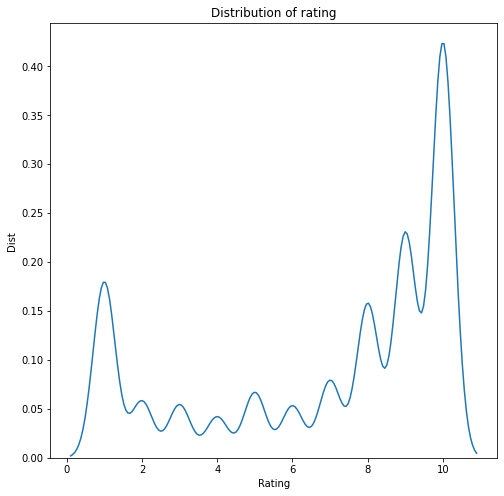

In [5]:
plt.figure(figsize=(8,8))
sns.distplot(d_train['rating'], hist=False)

plt.xlabel('Rating')
plt.ylabel('Dist')
plt.title("Distribution of rating")
plt.show()

#### 2. Counts of rating
각 rating별 실제 데이터 갯수를 확인한 결과, 10점을 준 리뷰가 약 50,000개(32%)로 가장 많은 수를 나타냈음

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


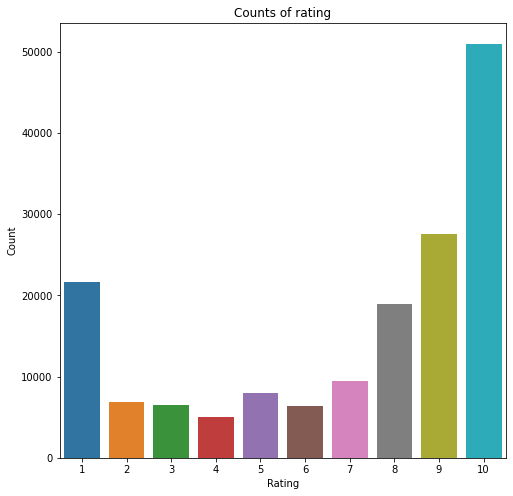

In [6]:
plt.figure(figsize=(8,8))
sns.countplot(d_train['rating'])

plt.xlabel('Rating')
plt.ylabel('Count')
plt.title("Counts of rating")
plt.show()

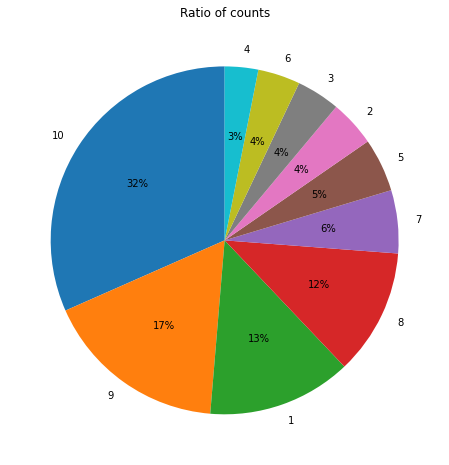

In [7]:
rating_ratio = d_train['rating'].value_counts() / d_train['rating'].count()
plt.figure(figsize=(8, 8))

plt.pie(rating_ratio, labels=rating_ratio.index, autopct='%1.f%%', startangle=90)
plt.title("Ratio of counts")
plt.show()

## 날짜별 리뷰 통계량
1. Reviews per year
2. Reviews per month
3. Reviews per day

#### 1. Reviews per year

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


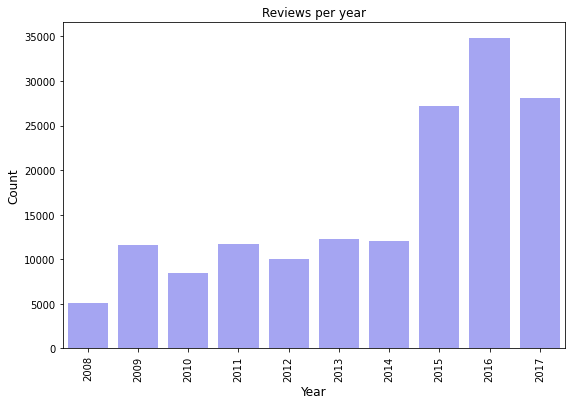

In [8]:
d_train['year'] = pd.to_datetime(d_train['date'], errors='coerce')
cnt = d_train['year'].dt.year.value_counts()
cnt = cnt.sort_index()
plt.figure(figsize=(9,6))
sns.barplot(cnt.index, cnt.values,color='blue',alpha=0.4)
plt.xticks(rotation='vertical')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Reviews per year")
plt.show()

#### 2. Reviews per month

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


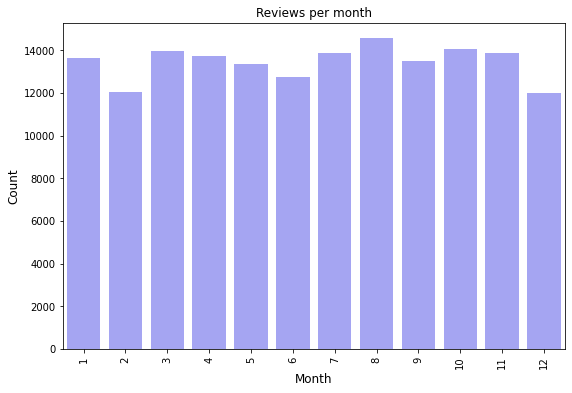

In [9]:
d_train['month'] = pd.to_datetime(d_train['date'], errors='coerce')
cnt = d_train['month'].dt.month.value_counts()
cnt = cnt.sort_index()
plt.figure(figsize=(9,6))
sns.barplot(cnt.index, cnt.values,color='blue',alpha=0.4)
plt.xticks(rotation='vertical')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Reviews per month")
plt.show()

#### 3. Reviews per day

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


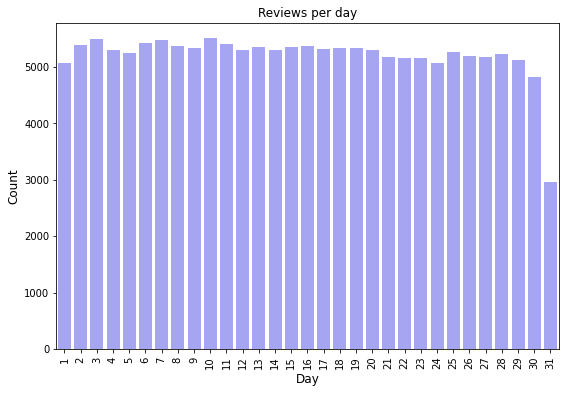

In [10]:
d_train['day'] = pd.to_datetime(d_train['date'], errors='coerce')
cnt = d_train['day'].dt.day.value_counts()
cnt = cnt.sort_index()
plt.figure(figsize=(9,6))
sns.barplot(cnt.index, cnt.values,color='blue',alpha=0.4)
plt.xticks(rotation='vertical')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Reviews per day")
plt.show()

## 추천수(usefulCount)별 통계량
유저에 남긴 리뷰에 대해 리뷰가 유용하다는 추천수(추천수가 해당 리뷰의 긍정, 부정을 나타내진 않음)
> 1. Distribution of usefulCount

#### 1. Distribution of usefulCount

###### Kaggle에서 사용된 코드   
왜 value_counts()를 사용하여 distplot 했는지 모르겠음

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


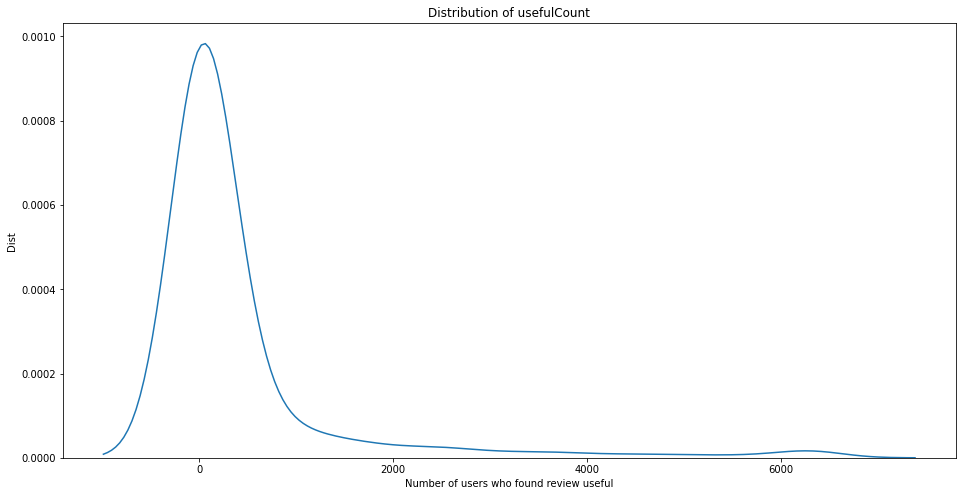

In [11]:
plt.figure(figsize=(16,8))

sns.distplot(d_train['usefulCount'].value_counts(), hist=False)


plt.xlabel('Number of users who found review useful')
plt.ylabel('Dist')
plt.title("Distribution of usefulCount")


plt.show()

###### 수정한 코드
value_counts()를 사용하지않고 distplot한 결과 그래프   
대부분의 usefulCount는 0 근처로 극히 일부만 200 이상의 usefulCount를 가지고 있음

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


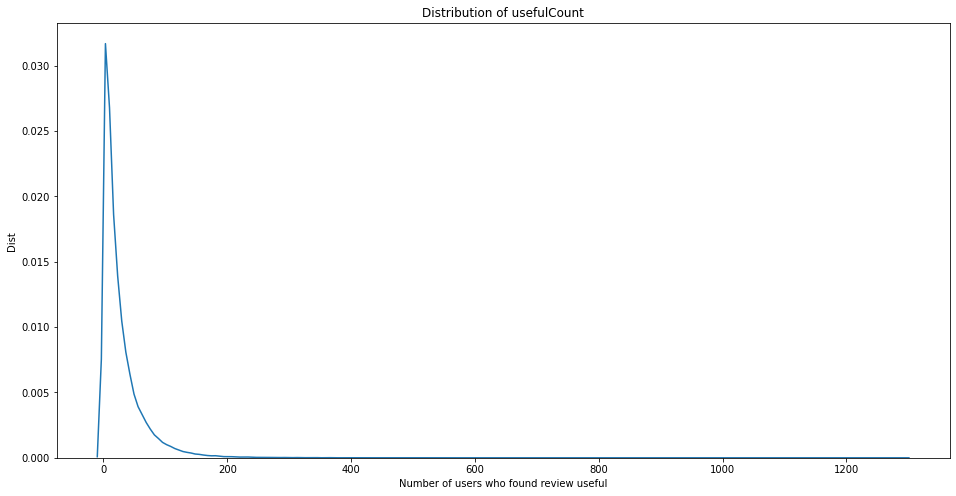

In [12]:
plt.figure(figsize=(16,8))

sns.distplot(d_train['usefulCount'], hist=False)


plt.xlabel('Number of users who found review useful')
plt.ylabel('Dist')
plt.title("Distribution of usefulCount")


plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


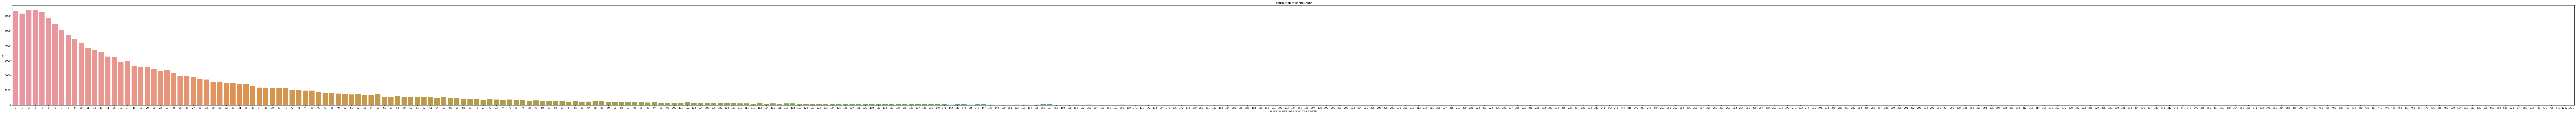

In [13]:
plt.figure(figsize=(200,8))

sns.countplot(d_train['usefulCount'])


plt.xlabel('Number of users who found review useful')
plt.ylabel('Dist')
plt.title("Distribution of usefulCount")


plt.show()

#### 2. usefulCount와 rating의 상관관계
usefulCount와 rating은 양의 상관관계를 가지고 있음

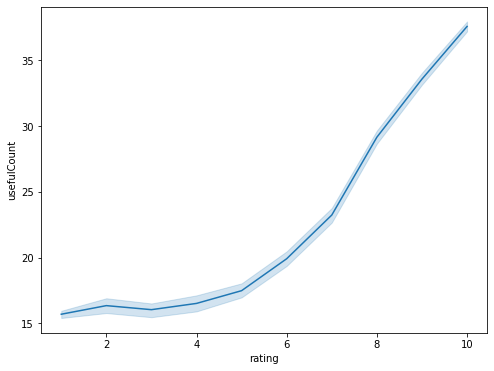

In [14]:
plt.figure(figsize=(8,6))

sns.lineplot(x='rating',y='usefulCount',data=d_train)

## Train and Test data 비교
Distribution of rating을 train set, test set을 함께 시각화한 결과   
test set도 train set과 마찬가지로 rating에 대해서 거의 동일한 분포를 나타냄

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


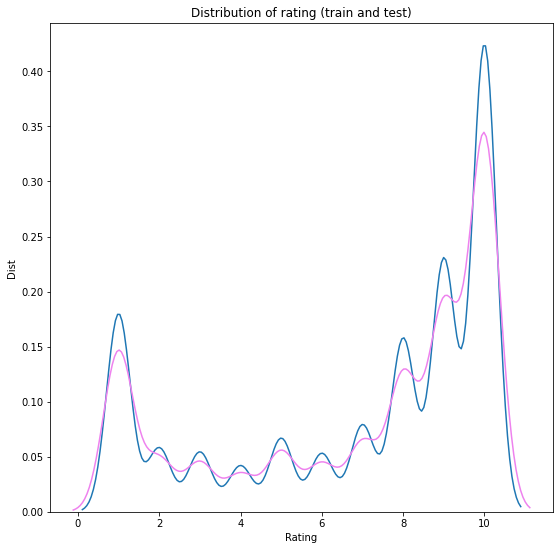

In [15]:
plt.figure(figsize=(9,9))

sns.distplot(d_train['rating'], hist=False)
sns.distplot(d_test['rating'],color='violet', hist=False)

plt.xlabel('Rating')
plt.ylabel('Dist')
plt.title("Distribution of rating (train and test)")

plt.show()

# 자연어 처리를 위한 모델학습
> * 워드 임베딩은 GloVe 방법론을 사용([정보](https://wikidocs.net/22885))
* 두 종류의 모델을 결합하여 학습
  * LSTM 모델   
  Attention mechanism을 사용하는 2계층의 LSTM 모델로써, 시퀀스 정보에 포커스를 맞춤
  * GRU 모델   
  GRU -> CNN -> Dense로 이루어진 모델로써, 문장의 구조 파악에 포커스를 맞춤
* 모델의 평가를 위해 K-Fold 교차검증 사용([정보](https://velog.io/@skyepodium/K-Fold-%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D))

## 텍스트 전처리 및 워드 임베딩
* Tokenizer를 통해 텍스트를 단어 기반으로 토큰화
* GloVe를 활용한 word embedding   
  * glove.840B.300d.txt 사용([다운로드](https://nlp.stanford.edu/projects/glove/))

In [16]:
train = pd.read_csv(conf["train_path"])
test = pd.read_csv(conf["test_path"])

X_train = train["review"]
y_train = train["rating"].values / 10

X_test = test["review"]
sample_pred = np.zeros_like(test["rating"], dtype=np.float32)

tokenizer = text.Tokenizer(num_words=conf["max_features"]) # num_words는 빈도 수에 따라 선택할 단어의 갯수를 정함 
tokenizer.fit_on_texts(list(X_train) + list(X_test)) # review 데이터를 통해 단어 인덱스를 구축
# review 문장을 숫자의 시퀀스로 변환
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
# 서로 다른 문장의 길이를 고정된 길이로 변환
x_train = sequence.pad_sequences(X_train, maxlen=conf["maxlen"])
x_test = sequence.pad_sequences(X_test, maxlen=conf["maxlen"])

In [17]:
if conf["kaggle"]: #tip: cause of config code style you can use same code of local experiments & for kaggle submission
    def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(conf["embedding_file"],encoding="UTF-8"))
else:
    with open(conf["embedding_pickle"], 'rb') as handle: #if you dont want to wait 6-9 minuts you can pickle your dict once
        embeddings_index = pickle.load(handle) # and just unpickle next, it may take near 10-20 seconds
    
word_index = tokenizer.word_index
nb_words = min(conf["max_features"], len(word_index))
embedding_matrix = np.zeros((nb_words, conf["embed_size"]))
for word, i in word_index.items():
    if i >= conf["max_features"]: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
conf["embedding_matrix"] = embedding_matrix

del embeddings_index
gc.collect()

50

## 첫 번째 모델
Attention mechanism을 사용한 LSTM 모델

In [22]:
class Attention(keras.layers.Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    
    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

    def get_config(self):
        config = super().get_config().copy()
        
        return config

In [19]:
def model_lstm_atten(main_conf: dict, model_conf:dict):
    inp = Input(shape=(main_conf["maxlen"], ))
    x = Embedding(main_conf["max_features"], main_conf["embed_size"], weights=[main_conf["embedding_matrix"]],trainable = False)(inp)
    x = Bidirectional(LSTM(model_conf["LSTM_first_layer_units"], return_sequences=True))(x)
    x = Bidirectional(LSTM(model_conf["LSTM_second_layer_units"], return_sequences=True))(x)
    x = Attention(main_conf["maxlen"])(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(1, activation="relu")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss=model_conf["loss"],optimizer=Adam(lr=model_conf["lr"]),metrics=model_conf["metrics"])
    
    return model

In [ ]:
kf = KFold(n_splits=conf["n_splits"], shuffle=True, random_state=conf["random_state"])
cnt = 0
model_conf["LSTM_first_layer_units"] = 128
model_conf["LSTM_second_layer_units"] = 64

for train_index, test_index in kf.split(x_train, y_train):
    model = model_lstm_atten(conf, model_conf)
    es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')

    hist = model.fit(x_train[train_index], y_train[train_index], batch_size=conf["batch_size"], epochs=conf["epochs"], 
                     validation_data=(x_train[test_index], y_train[test_index]),callbacks=[es])
    model.save(f"model_lstm_atten_cv_{cnt}.keras")
    
    sample_pred +=  model.predict(x_test, conf["batch_size"]*2).reshape(-1)
    cnt+=1

Epoch 1/500
49/49 [==============================] - 78s 1s/step - loss: 0.4319 - mae: 0.4319 - val_loss: 0.3085 - val_mae: 0.3085
Epoch 2/500
49/49 [==============================] - 69s 1s/step - loss: 0.3010 - mae: 0.3010 - val_loss: 0.2769 - val_mae: 0.2769
Epoch 3/500
49/49 [==============================] - 70s 1s/step - loss: 0.2686 - mae: 0.2686 - val_loss: 0.2483 - val_mae: 0.2483
Epoch 4/500
49/49 [==============================] - 69s 1s/step - loss: 0.2430 - mae: 0.2430 - val_loss: 0.2340 - val_mae: 0.2340
Epoch 5/500
49/49 [==============================] - 69s 1s/step - loss: 0.2324 - mae: 0.2324 - val_loss: 0.2249 - val_mae: 0.2249
Epoch 6/500
49/49 [==============================] - 69s 1s/step - loss: 0.2231 - mae: 0.2231 - val_loss: 0.2163 - val_mae: 0.2163
Epoch 7/500
49/49 [==============================] - 69s 1s/step - loss: 0.2138 - mae: 0.2138 - val_loss: 0.2076 - val_mae: 0.2076
Epoch 8/500
49/49 [==============================] - 69s 1s/step - loss: 0.2081 - m

## 두 번째 모델
GRU - CNN - Dense의 과정을 거치는 모델

In [20]:
def get_toxic_model(main_conf: dict, model_conf:dict):
    sequence_input = Input(shape=(main_conf["maxlen"], ))
    x = Embedding(main_conf["max_features"], main_conf["embed_size"], weights=[main_conf["embedding_matrix"]],trainable = False)(sequence_input)
    x = SpatialDropout1D(model_conf["SpDr"])(x)
    x = Bidirectional(GRU(model_conf["GRU_Units"], return_sequences=True))(x)
    x = Conv1D(model_conf["Conv_Units"], kernel_size = model_conf["conv_kernel"], padding = "valid", kernel_initializer = "glorot_uniform")(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])
    x = Dense(model_conf["Dense1_Unit"], activation='relu')(x)
    x = Dropout(model_conf["Dr1"])(x)
    x = Dense(model_conf["Dense2_Unit"], activation='relu')(x)
    x = Dropout(model_conf["Dr2"])(x)
    preds = Dense(1, activation="sigmoid")(x)
    model = Model(sequence_input, preds)
    model.compile(loss=model_conf["loss"],optimizer=Adam(lr=model_conf["lr"]),metrics=model_conf["metrics"])
    return model

In [ ]:
kf = KFold(n_splits=conf["n_splits"], shuffle=True, random_state=conf["random_state"])
cnt = 0

for train_index, test_index in kf.split(x_train, y_train):
    model = get_toxic_model(conf, model_conf)
    es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')

    hist = model.fit(x_train[train_index], y_train[train_index], batch_size=conf["batch_size"], epochs=conf["epochs"], 
                     validation_data=(x_train[test_index], y_train[test_index]),callbacks=[es])
    model.save(f"model_gru_cnn_{cnt}.keras")
    
    sample_pred +=  model.predict(x_test, conf["batch_size"]*2).reshape(-1)
    cnt+=1